Tras haber obtenido una aproximación de los mejores hiperparámetros para el genético con las métricas `internal_density` y `avg_odf`, hacemos las ejecuciones completas, evaluamos las soluciones contra las comunidades reales, y vemos qué zonas del Pareto obtienen mejores resultados.

In [1]:
%cd ..

/Users/pablomirallesgonzalez/Documents/masters-degree/Análisis de Redes Sociales/sna-ceb-assignment


In [2]:
import sys
sys.path.append('src')

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import functools
import random
import itertools

from cdlib import NodeClustering
from cdlib.evaluation import normalized_mutual_information

from genetic_operators import (
    tournament_select,
    random_locus_crossover,
    mutate_locus,
    mutate_locus_join,
    mutate_locus_separate,
    mutate_combine,
    create_locus,
)
from nsga2 import NSGA2
from disjoint_set_union import DisjointSetUnion
from metrics import build_metric
from plots import (
    plot_circular_community_graph_with_reference,
    plot_bipartite_community_graph,
    community_dict_to_list,
)

%matplotlib inline

## Carga de datos

Leemos el grafo, y preparamos unas estructuras de datos para pasar de etiquetas a índices, es decir, que el nodo i-ésimo se pueda identificar con el índice $i$ y con su etiqueta (e.g. `"1234"`) fácilmente.

In [4]:
GRAPH_FILE = "data/amazon_graph.graphml"
graph = nx.read_graphml(GRAPH_FILE)

In [5]:
nodes = list(graph.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
idx_to_node = {idx: node for idx, node in enumerate(nodes)}

edges: list[list[int]] = [
    list(set([ node_to_idx[neighbour] for neighbour in graph.neighbors(idx_to_node[idx]) ] + [idx]))
    for idx in range(graph.number_of_nodes())
]

## Código auxiliar

In [6]:
def individual_to_communities(individual: list[int]) -> list[list[int]]:
    """
    Given an individual of the genetic algorithm, return the communities it represents,
    with the original labels in the graph.
    """
    dsu = DisjointSetUnion(len(individual))
    for i1, i2 in enumerate(individual):
        dsu.join(i1, i2)
    components = dsu.get_components()
    communities = [[idx_to_node[idx] for idx in component] for component in components]
    return communities

Código para dibujar gráficos:

In [7]:
def get_pareto_front_idx(fitness_values: list[tuple[float, float]]) -> list[tuple[float, float]]:
    indices = sorted(
        range(len(fitness_values)),
        key=lambda idx: fitness_values[idx],
        reverse=True,
    )
    max_f2 = float("-inf")
    non_dominated = []
    for idx in indices:
        _, f2 = fitness_values[idx]
        if f2 <= max_f2:
            continue
        non_dominated.append(idx)
        max_f2 = f2
    return non_dominated

def plot_metric_on_pareto_front(
    ranked_population: list[tuple[int, float, tuple[float, float], list[int]]],
    metric: callable,
    metric_name: str,
):
    pareto_front_idx = get_pareto_front_idx([fitness for _, _, fitness, _ in ranked_population])

    metrics = []
    for idx in pareto_front_idx:
        _, _, fitness, individual = ranked_population[idx]
        communities = individual_to_communities(individual)
        metrics.append((*fitness, metric(communities)))

    metrics = np.array(metrics)
    # create two plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: avg_odf vs internal_density, with nmi as hue
    ax1.scatter(metrics[:, 0], metrics[:, 1], c=metrics[:, 2])
    ax1.set_xlabel("avg_odf")
    ax1.set_ylabel("internal_density")
    ax1.set_title(f"Pareto front with {metric_name} as hue")
    fig.colorbar(ax1.collections[0], ax=ax1)

    # Plot 2: barplot, x-axis is the order of the individual in the pareto front, y-axis is the nmi
    # apply cmap to the bars
    normalize = lambda x: (x - x.min()) / (x.max() - x.min())
    colors = plt.colormaps.get_cmap("viridis")(normalize(metrics[:, 2]))
    ax2.bar(range(len(metrics)), metrics[:, 2], color=colors)
    ax2.set_xlabel("Pareto, from larger avg_odf (left) to larger internal_density (right)")
    ax2.set_ylabel(metric_name)
    ax2.set_title(f"{metric_name} of individuals in the pareto front")

## Algoritmo evolutivo

In [8]:
BUDGET_FITNESS_CALLS = 50_000

def run(
    population_size: int,
    pcross: float,
    pmut: float,
    mutate_ratio_random: float,
    mutate_ratio_join: float,
    mutate_ratio_separate: float,
    T: int,
    metric_1: str,
    metric_2: str,
    trace: int = 25,
):
    ngen = BUDGET_FITNESS_CALLS // population_size
    mutate_fn_1 = functools.partial(mutate_locus, edges, mutate_ratio_random)
    mutate_fn_2 = functools.partial(mutate_locus_join, edges, mutate_ratio_join)
    mutate_fn_3 = functools.partial(mutate_locus_separate, mutate_ratio_separate)
    mutate_fn = functools.partial(mutate_combine, [mutate_fn_1, mutate_fn_2, mutate_fn_3])
    select_fn = functools.partial(tournament_select, T)
    metric_1 = build_metric(metric_1, graph)
    metric_2 = build_metric(metric_2, graph)

    def fitness_fn(individual: list[int]) -> tuple[float, float]:
        communities = individual_to_communities(individual)
        return metric_1(communities), metric_2(communities)

    population = create_locus(edges, population_size)

    ga = NSGA2[list[int], tuple[float, float]](
        fitness_fn=fitness_fn,
        select_fn=select_fn,
        crossover_fn=random_locus_crossover,
        mutate_fn=mutate_fn,
        pcross=pcross,
        pmut=pmut,
    )

    population_with_fitness = ga.run(population, ngen=ngen, trace=trace)

    return population_with_fitness

## Evaluación con comunidades reales

In [9]:
real_communities_dict = {node: attr["community"] for node, attr in list(graph.nodes(data=True))}
real_communities = community_dict_to_list(real_communities_dict)

## Obtención de soluciones

Uso dos métricas correlacionada negativamente:
* **Densidad interna media de las comunidades** o `internal_density`. Busca que los nodos de la misma comunidad estén muy conectados entre sí.
$$
\frac{1}{|C|} \sum_{S \in C} \left( 1 - \frac{m_s}{(n_s \cdot (n_s-1)) / 2} \right)
$$
* **Media de las fracciones de aristas que apuntan fuera de la comunidad** o `avg_odf`.
$$
\frac{1}{|C|} \sum_{S \in C} \frac{1}{n_S} \sum_{u \in S} \frac{| \{ (u,v):v\not\in S \} |}{d(u)}
$$

Los parámetros se obtienen por optimización del hipervolumen y la dispersión de Zitzler con la librería `optuna`. El archivo `scripts/exercise2_optuna_finetune.py` contiene el código de esto, y se lanza con la misma configuración que lo hice yo en `scripts/run_exercise2_optuna_finetune.sh`.

In [10]:
# best params
population_size = 60
pcross = 0.5
pmut = 0.25
mutate_ratio_random = 0.0038686204572240704
mutate_ratio_join = 0.12328015799522374
mutate_ratio_separate = 0.010267293463678674
T = 14

random.seed(42)

ranked_population = run(
    population_size=population_size,
    pcross=pcross,
    pmut=pmut,
    mutate_ratio_random=mutate_ratio_random,
    mutate_ratio_join=mutate_ratio_join,
    mutate_ratio_separate=mutate_ratio_separate,
    T=T,
    metric_1="avg_odf",
    metric_2="internal_density",
    trace=25,
)

Generation 0 - std_dev_fitness=[0.014451014576925918, 0.023713371142268007]
		Best value for objective 0: (0.3556245271073951, 0.4621197106042189)
		Best value for objective 1: (0.33573097467231505, 0.51499288999289)
Generation 25 - std_dev_fitness=[0.04670737943411937, 0.03477939384767779]
		Best value for objective 0: (0.780559647465864, 0.579402516401446)
		Best value for objective 1: (0.6584665527541385, 0.6744624730993527)
Generation 50 - std_dev_fitness=[0.07187055705686629, 0.07115130428265311]
		Best value for objective 0: (0.8509179721567528, 0.48543798385073)
		Best value for objective 1: (0.6218361827769879, 0.742688933536508)
Generation 75 - std_dev_fitness=[0.08632091384960731, 0.09875743944388019]
		Best value for objective 0: (0.8696390835861322, 0.4662676373913684)
		Best value for objective 1: (0.5929726582032916, 0.7918469400973482)
Generation 100 - std_dev_fitness=[0.10642257102140378, 0.10728763109377276]
		Best value for objective 0: (0.9028075152878077, 0.45533000

## Análisis de resultados
Obtenemos el frente de Pareto y lo dibujamos, junto con la información mutua respecto a las comunidades reales y el número de comunidades que se generan.

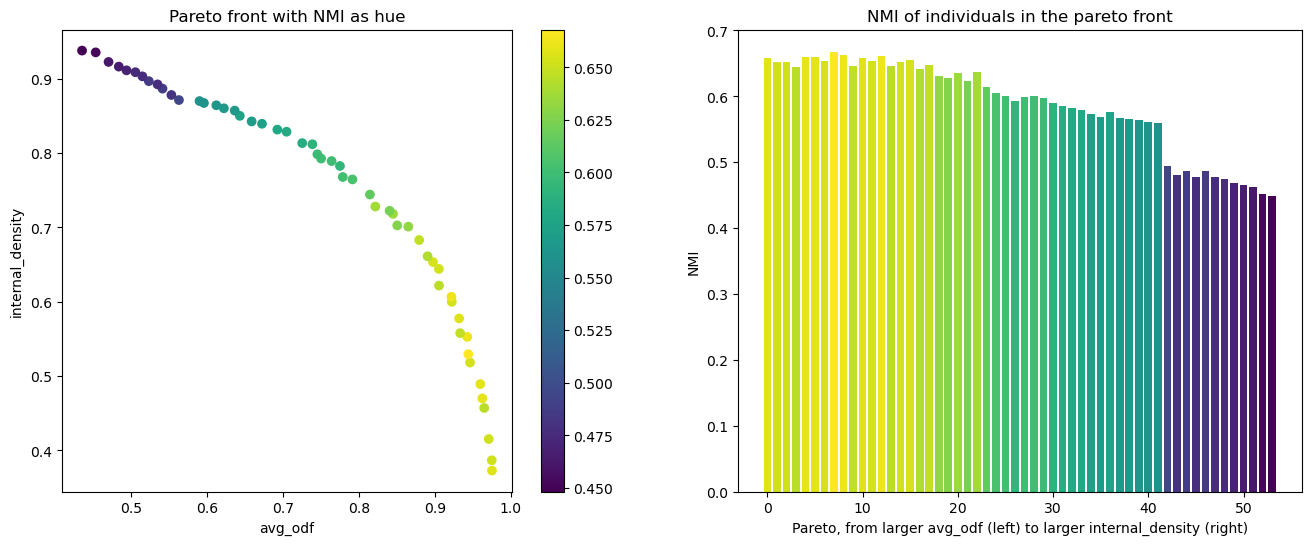

In [11]:
def nmi(communities: list[list[str]]) -> float:
    return normalized_mutual_information(
        NodeClustering(real_communities, graph),
        NodeClustering(communities, graph),
    ).score

plot_metric_on_pareto_front(ranked_population, nmi, "NMI")

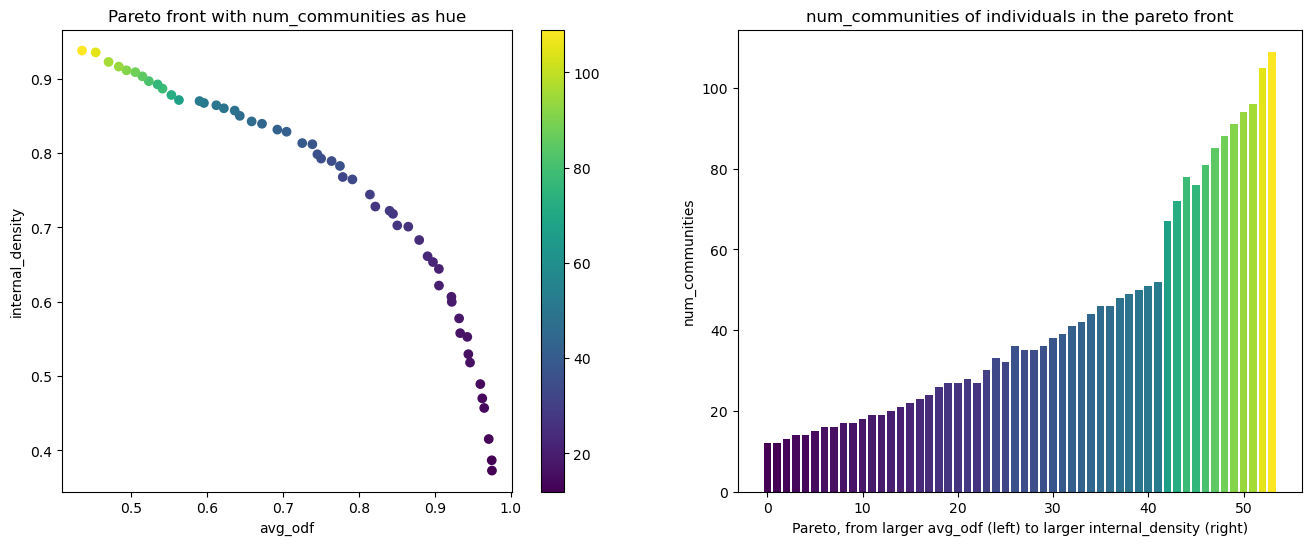

In [12]:
plot_metric_on_pareto_front(ranked_population, lambda communities: len(communities), "num_communities")

Vemos que cuanto más prioriza la fracción de nodos que apuntan fuera del clúster, más se parece a las comunidades reales, al menos respecto a la métrica de la información mutua.

Comparemos gráficamente la mejor solución con las comunidades reales.

In [13]:
best_solution = ranked_population[0][3]
best_nmi = nmi(individual_to_communities(best_solution))

metrics = []
for _, _, fitness, individual in ranked_population:
    communities = individual_to_communities(individual)
    nmi = normalized_mutual_information(
        NodeClustering(real_communities, graph),
        NodeClustering(communities, graph),
    ).score
    if nmi > best_nmi:
        best_nmi = nmi
        best_solution = individual
best_nmi

0.6679206436090083

In [14]:
best_communities = individual_to_communities(best_solution)

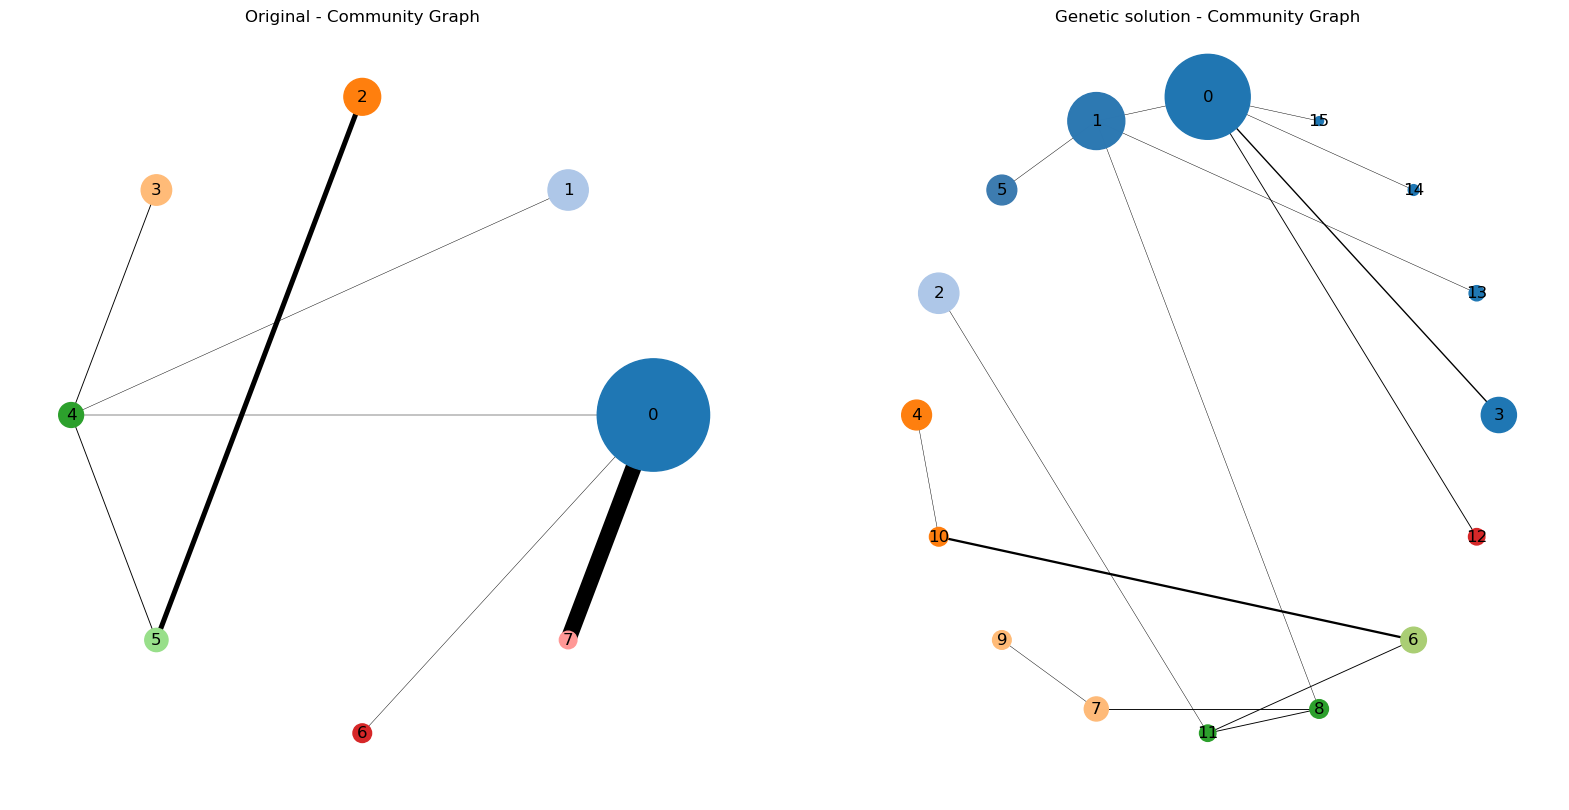

In [15]:
%matplotlib inline

# two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_circular_community_graph_with_reference(
    graph,
    communities_1=real_communities,
    communities_2=best_communities,
    node_scale=20.,
    ax1=ax1,
    ax2=ax2,
)

ax1.set_title("Original - Community Graph")
ax2.set_title("Genetic solution - Community Graph");

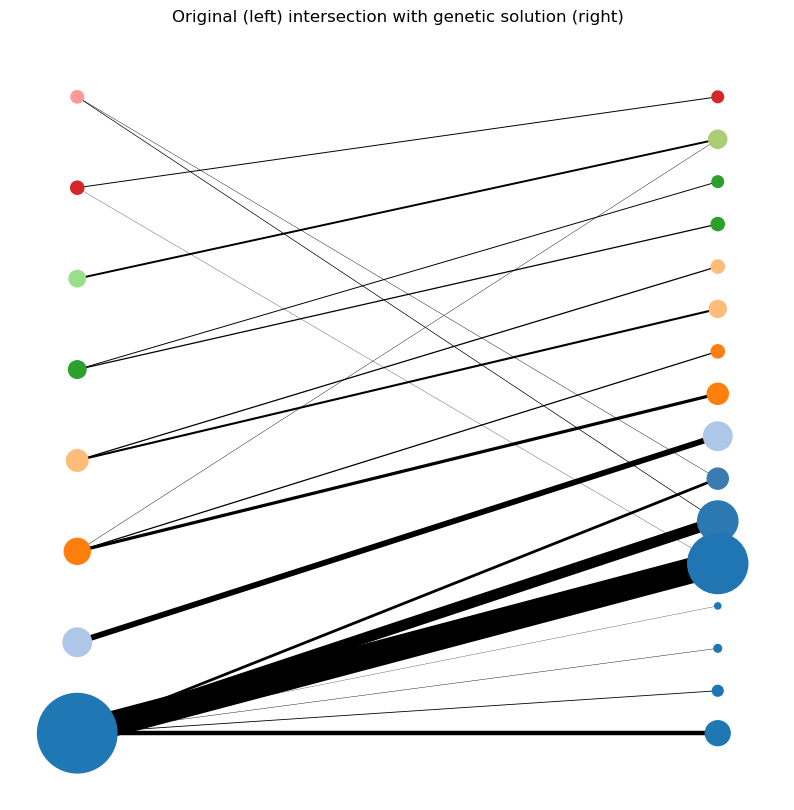

In [16]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_bipartite_community_graph(
    graph,
    communities_1=real_communities,
    communities_2=best_communities,
    node_scale=10.,
    edge_scale=0.1,
    ax=ax,
)

ax.set_title("Original (left) intersection with genetic solution (right)");

Vemos que es mucho más parecida que la solución con Leiden.

Finalmente, veamos la evolución dinámica dependiendo de la prioridad que tenga cada métrica, pasando por el frente de Pareto.

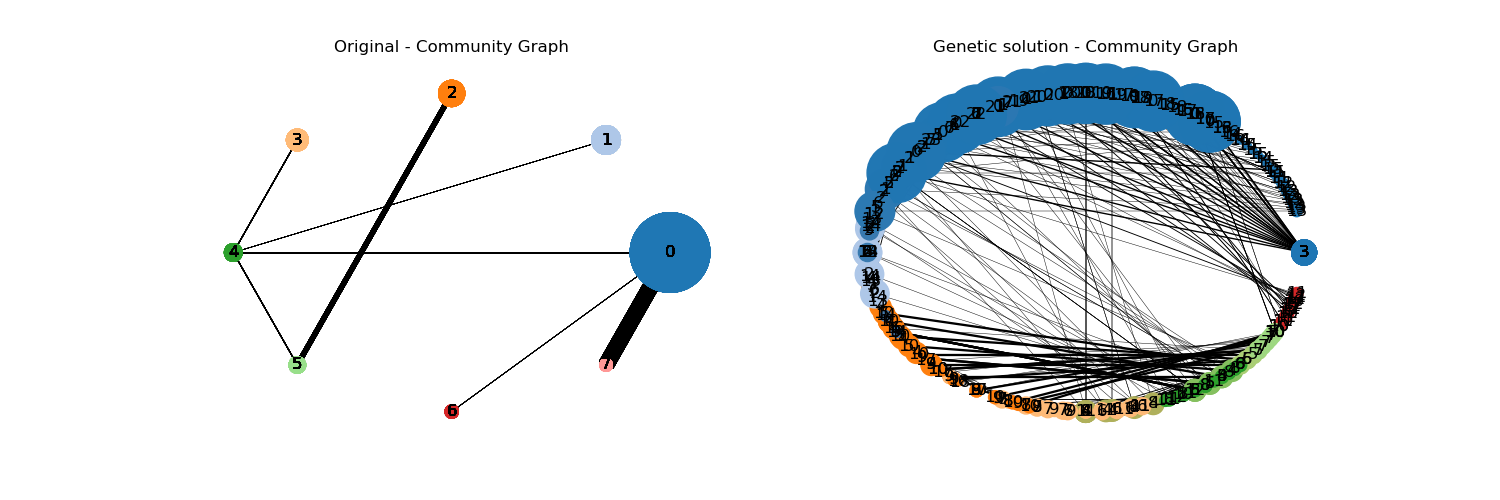

In [17]:
%matplotlib ipympl

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

pareto_front = [(fitness, individual) for rank, _, fitness, individual in ranked_population if rank == 0]
pareto_front.sort(key=lambda x: x[0], reverse=True)  # sort by avg_odf
def update(frame):
    ax.clear()
    communities = individual_to_communities(pareto_front[frame][1])
    plot_circular_community_graph_with_reference(
        graph,
        communities_1=real_communities,
        communities_2=communities,
        node_scale=10.,
        ax1=ax1,
        ax2=ax2,
    )
    ax1.set_title("Original - Community Graph")
    ax2.set_title("Genetic solution - Community Graph");

anim = animation.FuncAnimation(fig, update, frames=20, interval=1000, repeat=True)
anim.save('imgs/communities.gif', dpi=80, writer='imagemagick')
plt.show()